In [32]:
import numpy as np
import matplotlib.pyplot as plt
import random

def LoadBatch(filename):
    dict = unpickle(filename)
    X = dict['data']
    Y = dict['labels']
    Y_one_hot = one_hot_encode(Y)
    return X, Y, Y_one_hot

def unpickle(filename):
    """ Copied from the dataset website """
    import pickle
    with open('datasets/'+filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1') #encoding='latin1' is required for unpickling NumPy arrays
    return dict

def one_hot_encode(x):
    """
        argument
            - x: a list of labels
        return
            - one hot encoding matrix (number of labels, number of class)
    """
    encoded = np.zeros((len(x), 10))

    for idx, val in enumerate(x):
        encoded[idx][val] = 1

    return encoded

def normalize(x, mean, std):
    return (x-mean)/std

def reLu(x):
    return x*(x>0)

def softmax(x):
    """ Standard definition of code"""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def get_lamda(l_min, l_max):
    l = l_min + (l_max - l_min)*random.uniform(0,1)
    lamda = 10**l
    return lamda

def initialise_params(d, m, k):
    #Xavier Initialization
    sd1 = 1/np.sqrt(d)
    sd2 = 1/np.sqrt(m)
    W1 = np.random.normal(0, sd1, (m, d))
    W2 = np.random.normal(0, sd2, (k, m))
    b1 = np.zeros((m, 1))
    b2 = np.zeros((k, 1))
    return W1, W2, b1, b2

class MultiLayerImageClassifier():
    def __init__(self, W_1, W_2, b_1, b_2, hidden_nodes, label_count, e_min, e_max):
        self.W1 = W_1
        self.W2 = W_2
        self.b1 = b_1
        self.b2 = b_2
        self.M = hidden_nodes
        self.K = label_count
        self.eta_min = e_min
        self.eta_max = e_max
    
    def EvaluateClassifier(self, X):
        s1 = (self.W1 @ X.T) + self.b1
        h = reLu(s1)
        s = (self.W2 @ h) + self.b2
        p = softmax(s)    
        return p, h    
    
    def ComputeCost(self, X, Y, lamda):
        N = X.shape[0]
        p, _ = self.EvaluateClassifier(X)
        loss = 1/N * -np.sum(Y.T*np.log(p))
        cost =  loss + lamda * (np.sum(self.W1**2) + np.sum(self.W2**2))
        return cost, loss
        
    def ComputeAccuracy(self, X, Y):
        N = X.shape[0]
        p, _ = self.EvaluateClassifier(X)
        max_idx = np.argmax(p, axis=0)
        acc = np.count_nonzero((Y - max_idx)==0)/N
        return acc

    def ComputeGradients(self, X, Y, lamda):
        N = X.shape[0]
        P, H_batch = self.EvaluateClassifier(X)
        grad_batch = -(Y.T - P)
        grad_W2 = 1/N*(grad_batch @ H_batch.T) + 2*lamda*self.W2
        grad_b2 = np.reshape(1/N*(grad_batch @ np.ones(N)), (self.K, 1))
        grad_batch = self.W2.T @ grad_batch
        H_batch[H_batch <=0] = 0
        grad_batch = np.multiply(grad_batch, H_batch>0)
        grad_W1 = 1/N * (grad_batch @ X) + 2*lamda*self.W1 
        grad_b1 = np.reshape(1/N*(grad_batch @ np.ones(N)), (self.M, 1))
        return grad_W1, grad_b1, grad_W2, grad_b2

    def ComputeGradsNumSlow(self, X_batch, Y_batch, lamda=0, h=1e-5):
        """Numerically computes the gradients of the weight and bias parameters
        Args:
            X_batch (np.ndarray): data batch matrix (N, D)
            Y_batch (np.ndarray): one-hot-encoding labels batch vector (N, C)
            W       (np.ndarray): the weight matrix
            b       (np.ndarray): the bias matrix
            lamda        (float): penalty term
            h            (float): marginal offset
        Returns:
            grad_W  (np.ndarray): the gradient of the weight parameter
            grad_b  (np.ndarray): the gradient of the bias parameter
        """
        grads = {}
        for j in range(1, 3):
            selfW = getattr(self, 'W' + str(j))
            selfB = getattr(self, 'b' + str(j))
            grads['W' + str(j)] = np.zeros(selfW.shape)
            grads['b' + str(j)] = np.zeros(selfB.shape)

            b_try = np.copy(selfB)
            for i in range(selfB.shape[0]):
                selfB = b_try[:]
                selfB[j] = selfB[j] + h
                c2, _ = self.ComputeCost(X_batch, Y_batch, lamda)
                getattr(self, 'b' + str(j))[i] = getattr(self, 'b' + str(j))[i] - 2*h
                c3, _ = self.ComputeCost(X_batch, Y_batch, lamda)
                grads['b' + str(j)][i] = (c2-c3) / (2*h)

            W_try = np.copy(selfW)
            for i in np.ndindex(selfW.shape):
                selfW = W_try[:,:]
                selfW[i] = selfW[i] + h
                c2, _ = self.ComputeCost(X_batch, Y_batch, lamda)
                getattr(self, 'W' + str(j))[i] = getattr(self, 'W' + str(j))[i] - 2*h
                c3, _ = self.ComputeCost(X_batch, Y_batch, lamda)
                grads['W' + str(j)][i] = (c2-c3) / (2*h)

        return grads['W1'], grads['b1'], grads['W2'], grads['b2']

    def montage(self, W):
        """ Display the image for each label in W """
        fig, ax = plt.subplots(2,5)
        for i in range(2):
            for j in range(5):
                im = W [5 * i + j,:].reshape (32,32,3, order = 'F')
                sim = (im-np.min(im[:]))/(np.max(im[:])-np.min(im[:]))
                sim = sim.transpose(1,0,2)
                ax[i][j].imshow(sim, interpolation='nearest')
                ax[i][j].set_title("y="+str(5*i+j))
                ax[i][j].axis('off')
        plt.show()
        
    def mini_batch_gd(self, n_epochs, n, n_batch, X_train, Y_train, X_train_val, Y_train_val, Y_trn_lbl, Y_val_lbl, n_s, lamda):
        t = 0
#         l_min = 0.000302
#         l_max = 0.000377
        update_step=0
        eta = self.eta_min
        cost_train = []
        loss_train = []
        cost_vali = []
        loss_vali = []
        accuracy_train = []
        accuracy_val = []
        for epoch in range(n_epochs):
            if (epoch+1)%10 == 0:
                    print('Epoch' + str(epoch+1))
            X_batch = np.zeros((n_batch, X_train.shape[1]))
            Y_batch = np.zeros((n_batch, Y_train.shape[1]))
            #lamda = get_lamda(l_min, l_max)
            #lamda = np.random.uniform(l_min, l_max)
            #print("lamda - " + str(lamda))
            for j in range(int(n/n_batch)):
                start_idx = (j)*n_batch
                end_idx = (j+1)*n_batch
                X_batch = X_train[start_idx:end_idx, :]
                Y_batch = Y_train[start_idx:end_idx, :]
                #X_batch_val = X_train_val[start_idx:end_idx, :]
                #Y_batch_val = Y_train_val[start_idx:end_idx, :]
                Y_trn_labels = Y_trn_lbl[start_idx:end_idx]
                #Y_val_labels = Y_val_lbl[start_idx:end_idx]
                grad_w1, grad_b1, grad_w2, grad_b2 = self.ComputeGradients(X_batch, Y_batch, lamda)
                self.W1 -= eta * grad_w1
                self.b1 -= eta * grad_b1
                self.W2 -= eta * grad_w2
                self.b2 -= eta * grad_b2
                update_step+=1
                if t <= n_s:
                    eta = self.eta_min + t/n_s * (self.eta_max - self.eta_min)
                elif t <= 2*n_s:
                    eta = self.eta_max - (t - n_s)/n_s * (self.eta_max - self.eta_min)
                t = (t+1)%(2*n_s)
                cost_trn, loss_trn = self.ComputeCost(X_batch, Y_batch, lamda)
                cost_val, loss_val = self.ComputeCost(X_train_val, Y_train_val, lamda)
                train_acc = self.ComputeAccuracy(X_batch, Y_trn_labels)
                val_acc = self.ComputeAccuracy(X_train_val, Y_val_lbl)
                cost_train.append(cost_trn)
                loss_train.append(loss_trn)
                cost_vali.append(cost_val)
                loss_vali.append(loss_val)
                accuracy_train.append(train_acc)
                accuracy_val.append(val_acc)
#             print(train_acc)
#             print(val_acc)
        self.plot_performance(cost_train, cost_vali, update_step, 'cost')
        self.plot_performance(loss_train, loss_vali, update_step, 'loss')
        self.plot_performance(accuracy_train, accuracy_val, update_step, 'acc')
        return
    
    def plot_performance(self, train_data, val_data, update_step, plot_type):
        if plot_type == 'cost':
            plt.title('Cost Function')
        elif plot_type == 'loss':
            plt.title('Loss Function')
        elif plot_type == 'acc':
            plt.title('Accuracy')
        plt.xlim(0, update_step)
        plt.plot(train_data, label = "Training data")
        plt.plot(val_data, label = "Validation data")
        plt.legend()
        plt.savefig('result_pics_two_layer/' + plot_type + 'final_3_cycle.png')
        plt.show()
        

Epoch10


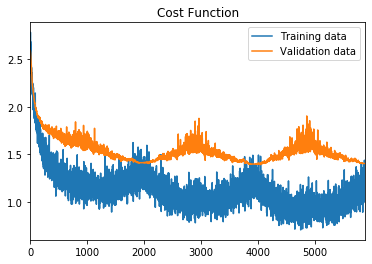

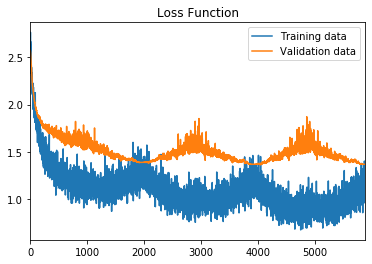

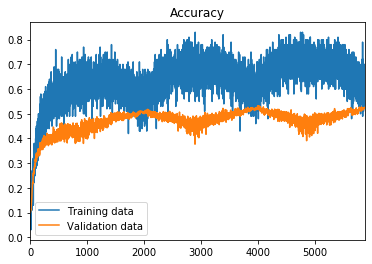

Accuracy on training data: 0.6078571428571429
Accuracy on validation data: 0.526
Accuracy on test data: 0.5112


In [33]:
X_train1, Y_train1, y_train_oh_1 = LoadBatch('data_batch_1')
X_train2, Y_train2, y_train_oh_2 = LoadBatch('data_batch_2')
X_train3, Y_train3, y_train_oh_3 = LoadBatch('data_batch_3')
X_train4, Y_train4, y_train_oh_4 = LoadBatch('data_batch_4')
X_train5, Y_train5, y_train_oh_5 = LoadBatch('data_batch_5')

X_train = np.vstack((X_train1, X_train2, X_train3, X_train4, X_train5))
Y_train = np.hstack((Y_train1, Y_train2, Y_train3, Y_train4, Y_train5))
Y_train_one_hot = np.vstack((y_train_oh_1, y_train_oh_2, y_train_oh_3, y_train_oh_4, y_train_oh_5))

X_test, Y_test, y_test_one_hot = LoadBatch('test_batch')

X_val = X_train[-1000:, :]
Y_val = Y_train[-1000:]
Y_val_one_hot = Y_train_one_hot[-1000:, :]

X_train = X_train[:-1000, :]
Y_train = Y_train[:-1000]
Y_train_one_hot = Y_train_one_hot[:-1000, :]

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

#Normalized data
img_trn_nrm = normalize(X_train, mean, std)
img_val_nrm = normalize(X_val, mean, std)
img_test_nrm = normalize(X_test, mean, std)

m = 50 #Hidden nodes
k = Y_train_one_hot.shape[1] #Label count
d = img_trn_nrm.shape[1]
e_min = 1e-5
e_max = 1e-1
w_1, w_2, b_1, b_2 = initialise_params(d, m, k)
imgClassifier = MultiLayerImageClassifier(w_1, w_2, b_1, b_2, m, k, e_min, e_max)

n = img_trn_nrm.shape[0]
n_batch = 100
n_s = 2*np.floor(n/n_batch)
n_epochs = 12
lamda = 0.00031 # Found by coarse and fine seacrh for reg term
imgClassifier.mini_batch_gd(n_epochs, n, n_batch, img_trn_nrm, Y_train_one_hot, img_val_nrm, Y_val_one_hot, Y_train, Y_val, n_s, lamda)


#Accuracy
train_acc = imgClassifier.ComputeAccuracy(img_trn_nrm, Y_train)
print('Accuracy on training data: ' + str(train_acc))
val_acc = imgClassifier.ComputeAccuracy(img_val_nrm, Y_val)
print('Accuracy on validation data: ' + str(val_acc))
test_acc = imgClassifier.ComputeAccuracy(img_test_nrm, Y_test)
print('Accuracy on test data: ' + str(test_acc))




In [271]:
#Compare gradients
reg = 1
eps = 0.001
grad_w1_fast, grad_b1_fast, grad_w2_fast, grad_b2_fast = imgClassifier.ComputeGradients(img_trn_nrm[0:1, :], Y_train_one_hot[0:1, :], reg)
grad_w1_slow, grad_b1_slow, grad_w2_slow, grad_b2_slow = imgClassifier.ComputeGradsNumSlow(img_trn_nrm[0:1, :], Y_train_one_hot[0:1, :], reg, 1e-6)
diff_w1 = np.abs(np.sum(grad_w1_fast) - np.sum(grad_w1_slow))/np.maximum(eps, np.abs(np.sum(grad_w1_fast)) + np.abs(np.sum(grad_w1_slow)))
diff_b1 = np.abs(np.sum(grad_b1_fast) - np.sum(grad_b1_slow))/np.maximum(eps, np.abs(np.sum(grad_b1_fast)) + np.abs(np.sum(grad_b1_slow)))
diff_w2 = np.abs(np.sum(grad_w2_fast) - np.sum(grad_w2_slow))/np.maximum(eps, np.abs(np.sum(grad_w2_fast)) + np.abs(np.sum(grad_w2_slow)))
diff_b2 = np.abs(np.sum(grad_b2_fast) - np.sum(grad_b2_slow))/np.maximum(eps, np.abs(np.sum(grad_b2_fast)) + np.abs(np.sum(grad_b2_slow)))
print(diff_w1)
print(diff_b1)
print(diff_w2)
print(diff_b2)

0.0003790416154821384
2.367526207604615e-07
7.391042214767419e-05
2.7755575615628914e-14
